<a href="https://colab.research.google.com/github/moaaz12-web/Transfer-learning-for-tumor-detection/blob/main/Brain_tumor_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORT DEPENDENCIES

[Dataset link](https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection)

In [2]:
! unzip /content/drive/MyDrive/data/br_detect.zip

Archive:  /content/drive/MyDrive/data/br_detect.zip
  inflating: Br35H-Mask-RCNN/TEST/annotations_test.json  
  inflating: Br35H-Mask-RCNN/TEST/y701.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y702.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y703.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y704.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y705.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y706.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y707.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y708.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y709.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y710.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y711.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y712.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y713.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y714.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y715.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y716.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y717.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y718.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y719.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y

In [3]:
import tensorflow as tf
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # -1  to USE CPU
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

get_ipython().magic(u'matplotlib inline')

# CROP IMAGE

**In this function we take in the input image and apply some preprocessing. We crop it, resize it, apply Gaussian Blur, and convert the color channels of the image as per our needs.**

In [4]:
def crop_brain_contour(image, plot=False):

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    return new_image

**Let's use the above function to see an input image example.**

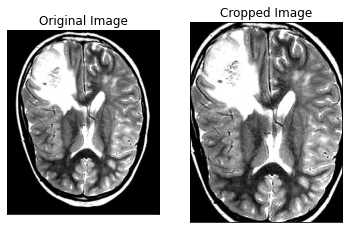

In [5]:
ex_img = cv2.imread('/content/yes/y0.jpg')

# Path to an input image in your drive
ex_new_img = crop_brain_contour(ex_img, True)

# LOAD THE DATASET

**In this function, we take in a list containing the path to our images, and a tuple specifying the image size (width and height). This function will output us an array of images (X) and their corresponding labels (tumorous or non-tumorous) (y)**

In [6]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    for directory in dir_list:
        for filename in listdir(directory):
            print(filename)
            print(directory)
            # load the image
            image = cv2.imread(directory + '/' + filename)
            # print(image)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
    X = np.array(X)
    y = np.array(y)
    # Shuffle the data
    X, y = shuffle(X, y)
    print('Number of examples is:{}'.format(len(X)))
    return X,y


In [7]:
folders = ['/content/yes', '/content/no']
img_size = (150,150)

In [8]:
X,y = load_data(folders, img_size)

Streaming output truncated to the last 5000 lines.
/content/yes
y1222.jpg
/content/yes
y936.jpg
/content/yes
y1266.jpg
/content/yes
y44.jpg
/content/yes
y103.jpg
/content/yes
y1289.jpg
/content/yes
y874.jpg
/content/yes
y980.jpg
/content/yes
y1324.jpg
/content/yes
y1057.jpg
/content/yes
y998.jpg
/content/yes
y784.jpg
/content/yes
y249.jpg
/content/yes
y1431.jpg
/content/yes
y1030.jpg
/content/yes
y577.jpg
/content/yes
y104.jpg
/content/yes
y1472.jpg
/content/yes
y391.jpg
/content/yes
y1115.jpg
/content/yes
y1214.jpg
/content/yes
y568.jpg
/content/yes
y469.jpg
/content/yes
y21.jpg
/content/yes
y896.jpg
/content/yes
y1256.jpg
/content/yes
y86.jpg
/content/yes
y1288.jpg
/content/yes
y1372.jpg
/content/yes
y1191.jpg
/content/yes
y233.jpg
/content/yes
y516.jpg
/content/yes
y1046.jpg
/content/yes
y742.jpg
/content/yes
y525.jpg
/content/yes
y235.jpg
/content/yes
y702.jpg
/content/yes
y1406.jpg
/content/yes
y635.jpg
/content/yes
y1165.jpg
/content/yes
y760.jpg
/content/yes
y551.jpg
/content/ye

In [9]:
X  #Lets check X

array([[[[0.02745098, 0.02745098, 0.02745098],
         [0.02352941, 0.02352941, 0.02352941],
         [0.02745098, 0.02745098, 0.02745098],
         ...,
         [0.03137255, 0.03137255, 0.03137255],
         [0.03137255, 0.03137255, 0.03137255],
         [0.02745098, 0.02745098, 0.02745098]],

        [[0.03529412, 0.03529412, 0.03529412],
         [0.03137255, 0.03137255, 0.03137255],
         [0.03529412, 0.03529412, 0.03529412],
         ...,
         [0.03529412, 0.03529412, 0.03529412],
         [0.03137255, 0.03137255, 0.03137255],
         [0.03137255, 0.03137255, 0.03137255]],

        [[0.03921569, 0.03921569, 0.03921569],
         [0.03921569, 0.03921569, 0.03921569],
         [0.04313725, 0.04313725, 0.04313725],
         ...,
         [0.03529412, 0.03529412, 0.03529412],
         [0.03137255, 0.03137255, 0.03137255],
         [0.03137255, 0.03137255, 0.03137255]],

        ...,

        [[0.03137255, 0.03137255, 0.03137255],
         [0.03137255, 0.03137255, 0.03137255]

In [10]:
y #Lets check y

array([[0],
       [1],
       [1],
       ...,
       [0],
       [1],
       [1]])

# SPLIT THE DATASET

**In this function, we split the whole dataset into training, validation, and testing data. We will use 80% of the data for training, 45% for validation, and 45% for testing**

In [11]:
def split_data(X, y, test_size=0.2):

    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size, random_state=42)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [12]:
del X
del y
# Let's delete X and y to free up memory

In [13]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 2100
number of validation examples = 450
number of test examples = 450
X_train shape: (2100, 150, 150, 3)
Y_train shape: (2100, 1)
X_val (dev) shape: (450, 150, 150, 3)
Y_val (dev) shape: (450, 1)
X_test shape: (450, 150, 150, 3)
Y_test shape: (450, 1)


# FUNCTION FOR COMPUTING THE F1-SCORE

In [14]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    score = f1_score(y_true, y_pred)

    return score

# BUILDING THE CNN MODEL

In [15]:
def build_model(input_shape):
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape)
    X = Conv2D(64, (3, 3), strides = (1, 1), padding='valid', name = 'conv0')(X_input)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # 

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool0')(X)

    X = Conv2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(X)
    X = BatchNormalization(axis=3, name='bn1')(X)
    X = Activation('relu')(X)  

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool1')(X) 
    X=Dropout(0.50)(X)

    X = Conv2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv2')(X)
    X = BatchNormalization(axis=3, name='bn2')(X)
    X = Activation('relu')(X) 

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool2')(X) 

    # FLATTEN X 
    X = Flatten()(X) 

    # FULLYCONNECTED
    X = Dense(32, activation='relu', name='fc_myself')(X) 

    X = Dense(1, activation='sigmoid', name='fc')(X) 

    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')

    return model

# LET'S SEE A SUMMARY OF THE MODEL

In [16]:
IMG_SHAPE = (150, 150, 3)
model = build_model(IMG_SHAPE)
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv0 (Conv2D)              (None, 148, 148, 64)      1792      
                                                                 
 bn0 (BatchNormalization)    (None, 148, 148, 64)      256       
                                                                 
 activation (Activation)     (None, 148, 148, 64)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 74, 74, 64)        0         
                                                                 
 conv1 (Conv2D)              (None, 36, 36, 64)        36928     
                                                                 
 bn1 (BatchNormalization)    (None, 36, 36, 64)

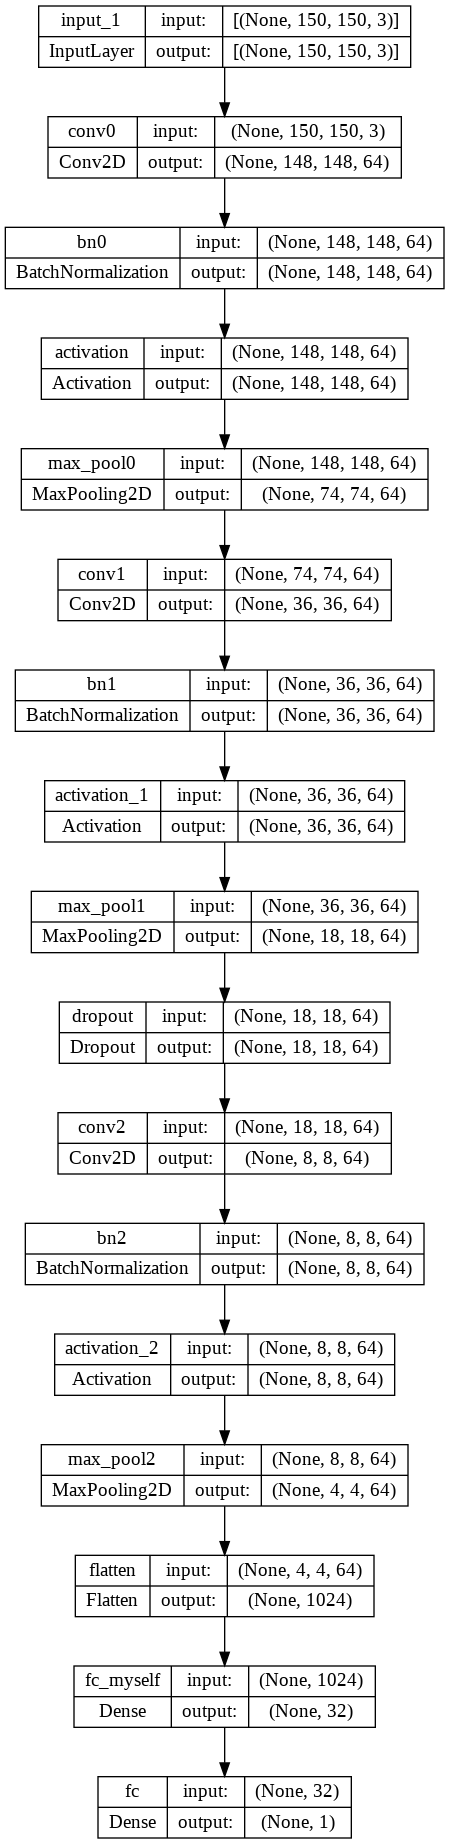

In [17]:
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense


# Generate a flow chart of the model
plot_model(model, to_file='model_flowchart.png', show_shapes=True)


# COMPILE THE MODEL

In [18]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

In [19]:
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])


import time

# tensorboard
log_file_name = 'brain_tumor_detection_cnn_{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(log_file_name))




# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="/cnn_parameters_improvement_{epoch:02d}_{val_acc:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("/models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

In [20]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.35,
                              patience=4, min_lr=0.001)

# FIT THE MODEL

In [ ]:
model.fit(x=X_train, y=y_train, batch_size=128, epochs=50, validation_data=(X_val, y_val), callbacks=[reduce_lr,tensorboard])

Epoch 1/50
17/17 [==============================] - 4s 176ms/step - loss: 0.7899 - accuracy: 0.5967 - val_loss: 0.6844 - val_accuracy: 0.5778 - lr: 0.0010
Epoch 2/50
17/17 [==============================] - 2s 139ms/step - loss: 0.5987 - accuracy: 0.6752 - val_loss: 0.6767 - val_accuracy: 0.6378 - lr: 0.0010
Epoch 3/50
17/17 [==============================] - 2s 147ms/step - loss: 0.5287 - accuracy: 0.7448 - val_loss: 0.6785 - val_accuracy: 0.5267 - lr: 0.0010
Epoch 4/50
17/17 [==============================] - 3s 150ms/step - loss: 0.4782 - accuracy: 0.7729 - val_loss: 0.6738 - val_accuracy: 0.5600 - lr: 0.0010
Epoch 5/50
17/17 [==============================] - 2s 145ms/step - loss: 0.4271 - accuracy: 0.8057 - val_loss: 0.6699 - val_accuracy: 0.5489 - lr: 0.0010
Epoch 6/50
17/17 [==============================] - 2s 139ms/step - loss: 0.4043 - accuracy: 0.8157 - val_loss: 0.6589 - val_accuracy: 0.7467 - lr: 0.0010
Epoch 7/50
17/17 [==============================] - 2s 138ms/step - lo

# SAVE THE MODEL TO GOOGLE DRIVE

In [21]:
from keras.models import load_model

model.save('/content/drive/MyDrive/data/saved_model_latest_latest_1-5.h5')  # creates a HDF5 file 'my_model.h5' in ur google drive

# model = tf.keras.models.load_model('/content/drive/MyDrive/data/saved_model_latest_latest.h5')
# 

In [22]:
history = model.history.history

for key in history.keys():
    print(key)

AttributeError: ignored

# PLOT EVALUATION METRICS

In [23]:
def plot_metrics(history):

    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']

    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()




plot_metrics(history)

NameError: ignored

In [ ]:
model.metrics_names


['loss', 'accuracy']

# EVALUATION ON VALIDATION DATA

In [24]:
loss, acc = model.evaluate(x=X_val, y=y_val)


15/15 [==============================] - 7s 20ms/step - loss: 0.0902 - accuracy: 0.9756


In [25]:
print ("Validation Loss = {}".format(loss))
print ("Validation Accuracy = {}%".format(np.around(acc*100)))

Validation Loss = 0.0901670753955841
Validation Accuracy = 98.0%


# PREDICTIONS ON TESTING DATA

In [26]:
y_test_prob = model.predict(X_test)
y_test_prob

15/15 [==============================] - 0s 12ms/step


array([[9.99907732e-01],
       [2.47749221e-02],
       [9.99997735e-01],
       [9.99999642e-01],
       [9.92119431e-01],
       [6.52477052e-03],
       [9.99992609e-01],
       [9.99805868e-01],
       [8.82638991e-01],
       [9.99998212e-01],
       [6.50426373e-03],
       [9.99910116e-01],
       [9.98349309e-01],
       [9.99210715e-01],
       [9.97475207e-01],
       [9.99758661e-01],
       [1.00000000e+00],
       [9.99996066e-01],
       [8.23042840e-02],
       [9.95686412e-01],
       [4.52287868e-03],
       [9.03246924e-02],
       [6.00831257e-03],
       [7.74192682e-04],
       [1.94539249e-01],
       [7.29341246e-03],
       [2.26154132e-03],
       [9.77025747e-01],
       [6.26831800e-02],
       [9.42285545e-03],
       [1.39101269e-02],
       [9.99994755e-01],
       [5.59281446e-02],
       [6.10710029e-03],
       [3.07490546e-02],
       [1.53203204e-04],
       [3.33906859e-02],
       [9.99998331e-01],
       [5.27398894e-03],
       [4.06007562e-03],


In [27]:
y_test_hat_rounded = np.around(y_test_prob)   # this would convert [0.87, 0.13] to [1., 0.]
y_test_hat_rounded

array([[1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],

# F1-SCORE ON TESTING DATA

In [28]:
f1score = compute_f1_score(y_test, y_test_hat_rounded)


In [29]:
f1score

0.9770992366412213

# GENERAL INFO ABOUT THE DATASET

In [ ]:
def data_percentage(y):

    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive

    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m

    print("Number of examples:{}".format(m))
    print("Percentage of positive examples: {}%, number of pos examples: {}".format(pos_prec,n_positive))
    print("Percentage of negative examples: {}%, number of neg examples: {}".format(neg_prec,n_negative))

In [ ]:
y = np.concatenate((y_train, y_test, y_val), axis=0)
data_percentage(y)

Number of examples:3000
Percentage of positive examples: 50.0%, number of pos examples: 1500
Percentage of negative examples: 50.0%, number of neg examples: 1500


In [ ]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples:2100
Percentage of positive examples: 49.904761904761905%, number of pos examples: 1048
Percentage of negative examples: 50.095238095238095%, number of neg examples: 1052
Validation Data:
Number of examples:450
Percentage of positive examples: 51.55555555555556%, number of pos examples: 232
Percentage of negative examples: 48.44444444444444%, number of neg examples: 218
Testing Data:
Number of examples:450
Percentage of positive examples: 48.888888888888886%, number of pos examples: 220
Percentage of negative examples: 51.111111111111114%, number of neg examples: 230


# MAKING PREDICTIONS ON IMAGES

**Let us upload an image, plot it, examine it, and convert it to a numpy array.**

In [33]:
from google.colab import files
uploaded = files.upload()


# list of image files 
image_list = os.listdir('/content')
      
for i in image_list: 
    # Loading the image 
    # img = cv2.imread(image) 
  
    # detecting the type of image 
    extension = os.path.splitext(i)[1] 

    if extension == ".jpg" or extension == ".jfif" or extension == ".png" or extension == ".jpeg":

      image = cv2.imread('/content/'+i)
      image = crop_brain_contour(image, plot=False)
      image = cv2.resize(image, dsize=(150, 150), interpolation=cv2.INTER_CUBIC)
      image = image / 255.

      res = transfer_model.predict( np.array( [image,] )  )

      if res[0] > 0.5:
        plt.imshow(image)
        plt.title("TUMOR DETECTED")
        print(f"The input image has tumor with {res[0][0]*100}% accuracy")
      else:
        plt.imshow(image)
        plt.title("NO TUMOR DETECTED")
        print(f"The input image has no tumor with {(1 - res[0][0])*100}% accuracy") 

    else:
      pass

NameError: ignored

In [ ]:
image

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving download.jpeg to download.jpeg


**Now let us pass it to our model for predictions.**

In [ ]:
image = cv2.imread('/content/download.jpeg')

image = crop_brain_contour(image, plot=False)


image = cv2.resize(image, dsize=(150, 150), interpolation=cv2.INTER_CUBIC)

image = image / 255.

plt.imshow(image)

plt.title("INPUT IMAGE (with tumor)");

In [ ]:

res = model.predict( np.array( [image,] )  )


In [ ]:
if res[0] > 0.5:
  print(f"The input image has tumor with {res[0][0]*100}% accuracy")
else:
  print(f"The input image has no tumor with {(1 - res[0][0])*100}% accuracy")